# **Data process**

## Đổi tên các cột concat()

In [1]:
import pandas as pd

anno_df = pd.read_csv('/kaggle/input/project2-cs114-data/wecode.data/annonimized.csv')

anno_df.rename(columns={
    "concat('it001',`assignment_id`)": 'a_id',
    "concat('it001',`problem_id`)": 'p_id',
    "concat('it001', username)": 'username',
    "concat('it001',`language_id`)": 'lang_id',
}, inplace=True)

TOTAL_ASSIGNMENTS = len(anno_df['a_id'].unique())
TOTAL_PROBLEMS = len(anno_df.drop_duplicates(subset=['a_id', 'p_id']))
anno_cop = anno_df.copy()
anno_df.head()

,a_id,p_id,username,is_final,status,pre_score,coefficient,lang_id,created_at,updated_at,judgement
0,90ce27571176d87961b565d5ef4b3de33ede04ac,789454427dd4097a14749e3dde63346b7a8d3811,ed9eaeb6a707f50154024b24d7efcb874a9795dd,0,SCORE,0,100,it0012,10-09 08:02:04,10-09 08:06:58,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0..."
1,90ce27571176d87961b565d5ef4b3de33ede04ac,789454427dd4097a14749e3dde63346b7a8d3811,ed9eaeb6a707f50154024b24d7efcb874a9795dd,0,SCORE,0,100,it0012,10-09 08:04:41,10-09 08:04:51,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0..."
2,90ce27571176d87961b565d5ef4b3de33ede04ac,789454427dd4097a14749e3dde63346b7a8d3811,ed9eaeb6a707f50154024b24d7efcb874a9795dd,1,SCORE,10000,100,it0012,10-09 08:06:49,10-09 08:06:58,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0..."
3,90ce27571176d87961b565d5ef4b3de33ede04ac,bf96fbdc5f499538c3e2bfbec5779c8a14b0a9ff,ed9eaeb6a707f50154024b24d7efcb874a9795dd,1,SCORE,10000,100,it0012,10-09 08:47:52,10-09 08:48:01,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0..."
4,90ce27571176d87961b565d5ef4b3de33ede04ac,7a6e5ca470ff47c3b5048f240c4738de71010c78,ed9eaeb6a707f50154024b24d7efcb874a9795dd,1,SCORE,10000,100,it0012,10-09 09:19:35,10-09 09:19:45,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0..."


## Xử lí judgement

In [2]:
import json

def safe_parse_judgement(j):
    try:
        data = json.loads(j)
        return pd.Series({
            'times': data.get('times', []),
            'mems': data.get('mems', []),
            'verdicts': data.get('verdicts', {})
        })
    except:
        return pd.Series({'times': [], 'mems': [], 'verdicts': {}})

anno_df[['times', 'mems', 'verdicts']] = anno_df['judgement'].apply(safe_parse_judgement)
anno_df.drop('judgement', axis=1, inplace=True)
anno_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295198 entries, 0 to 295197
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   a_id         295198 non-null  object
 1   p_id         295198 non-null  object
 2   username     295198 non-null  object
 3   is_final     295198 non-null  int64 
 4   status       295198 non-null  object
 5   pre_score    295198 non-null  int64 
 6   coefficient  295198 non-null  int64 
 7   lang_id      295198 non-null  object
 8   created_at   295198 non-null  object
 9   updated_at   295198 non-null  object
 10  times        295198 non-null  object
 11  mems         295198 non-null  object
 12  verdicts     295198 non-null  object
dtypes: int64(3), object(10)
memory usage: 29.3+ MB


# **Trích xuất đặc trưng sinh viên**

## Đếm số lượng assignment đã tham gia

In [3]:
num_assignments = (
    anno_df[['username', 'a_id']]
    .drop_duplicates()
    .groupby('username')
    .size()
    .reset_index(name='num_assignments')
)

num_assignments

,username,num_assignments
0,00b6dd4fc7eb817e03708c532016ef30ce564a61,7
1,00bef8afee8f3c595d535c9c03c490cac1a4f021,9
2,01122b3ef7e59b84189e65985305f575d6bdf83c,7
3,0134f9f410c65ad0e8c2254a7e9288670e02a183,4
4,013de369c439ab0ead8aa7da64423aa395a8be39,8
...,...,...
1484,feb8a2859a011c59efd22ed419cb69288fe03627,9
1485,fef4a3263ed9a8ab14d457694bb8fd86ccd98312,6
1486,ff12d6e2ab80696ed8e22fbe5497e96c68d29076,6
1487,ff3fa2ec64294f37ae968159f810ebeda7966c51,7


## Asignment mà sinh viên đó tham gia

In [4]:
asignments_df = pd.crosstab(
    anno_df.drop_duplicates(subset=['username', 'a_id'])['username'],
    anno_df.drop_duplicates(subset=['username', 'a_id'])['a_id']
)
asignments_df

a_id,0110c1b3d0b4a08b95e05a48be6924e043e68ffe,013a41bc4aab7ce974228df5a2b5d5e6e0da64e8,0271545dae97fb752a588e6b97d55e4009565b35,02b71138af0269da597fee7614137d3a0ad75326,03190ab3ec4705c66358cd102fdb719bc8ab13bb,03c6ca1a06d190e840f2a268206547e3b811ee53,0476d51e316bc37953f5003daeb859f057167b59,06e1a6e795e5bc066dd12707b400d286653b1173,06f25f8358db79e5ab8b5d52fe604d9b7efda10d,0740cc9703b71bd5799da8acd34e84044464aa4a,...,f86c876f6d60b3b0c14fb0f084c705f1c4bb3dad,f89d30fccecbe52278b59e9294d868e3c51fbff4,f8d46b863c7cb8ec934fa0043264dfdb01209630,fa76cedef89934b5a8c9b6f93744b2cbdd941e6d,fd8fdf743e38d0dc3e613563f3ce1ad0301235bb,fdb39b60bce4591bdac572cc1f03d4f3417df16e,fe1bf6b299645a8e2502b0a43fa57d650d1b1b41,feac75b57862fb1653d3835bea439742ea93c8c8,febe93930de7a9a910e8a55177a7bce45de7329b,ff1bb207f10b6d6999751f65f3abf047f2b9242c
username,,,,,,,,,,,,,,,,,,,,,
00b6dd4fc7eb817e03708c532016ef30ce564a61,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00bef8afee8f3c595d535c9c03c490cac1a4f021,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
01122b3ef7e59b84189e65985305f575d6bdf83c,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0134f9f410c65ad0e8c2254a7e9288670e02a183,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
013de369c439ab0ead8aa7da64423aa395a8be39,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
feb8a2859a011c59efd22ed419cb69288fe03627,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
fef4a3263ed9a8ab14d457694bb8fd86ccd98312,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
ff12d6e2ab80696ed8e22fbe5497e96c68d29076,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
asignments_df = pd.crosstab(
    anno_df.drop_duplicates(subset=['username', 'a_id'])['username'],
    anno_df.drop_duplicates(subset=['username', 'a_id'])['a_id']
)
asignments_df

a_id,0110c1b3d0b4a08b95e05a48be6924e043e68ffe,013a41bc4aab7ce974228df5a2b5d5e6e0da64e8,0271545dae97fb752a588e6b97d55e4009565b35,02b71138af0269da597fee7614137d3a0ad75326,03190ab3ec4705c66358cd102fdb719bc8ab13bb,03c6ca1a06d190e840f2a268206547e3b811ee53,0476d51e316bc37953f5003daeb859f057167b59,06e1a6e795e5bc066dd12707b400d286653b1173,06f25f8358db79e5ab8b5d52fe604d9b7efda10d,0740cc9703b71bd5799da8acd34e84044464aa4a,...,f86c876f6d60b3b0c14fb0f084c705f1c4bb3dad,f89d30fccecbe52278b59e9294d868e3c51fbff4,f8d46b863c7cb8ec934fa0043264dfdb01209630,fa76cedef89934b5a8c9b6f93744b2cbdd941e6d,fd8fdf743e38d0dc3e613563f3ce1ad0301235bb,fdb39b60bce4591bdac572cc1f03d4f3417df16e,fe1bf6b299645a8e2502b0a43fa57d650d1b1b41,feac75b57862fb1653d3835bea439742ea93c8c8,febe93930de7a9a910e8a55177a7bce45de7329b,ff1bb207f10b6d6999751f65f3abf047f2b9242c
username,,,,,,,,,,,,,,,,,,,,,
00b6dd4fc7eb817e03708c532016ef30ce564a61,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00bef8afee8f3c595d535c9c03c490cac1a4f021,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
01122b3ef7e59b84189e65985305f575d6bdf83c,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0134f9f410c65ad0e8c2254a7e9288670e02a183,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
013de369c439ab0ead8aa7da64423aa395a8be39,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
feb8a2859a011c59efd22ed419cb69288fe03627,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
fef4a3263ed9a8ab14d457694bb8fd86ccd98312,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
ff12d6e2ab80696ed8e22fbe5497e96c68d29076,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Đếm số lượng cột Status là SCORE và Error

In [6]:
filtered_df = anno_df[anno_df['status'] == 'SCORE']

num_score = filtered_df.groupby('username').size().reset_index(name='score_count')

num_score.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1475 entries, 0 to 1474
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   username     1475 non-null   object
 1   score_count  1475 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 23.2+ KB


In [7]:
filtered_df = anno_df[(anno_df['status'] == 'Compilation Error') | (anno_df['status'] == 'Syntax Error')]

num_error = filtered_df.groupby('username').size().reset_index(name='compilation_error_count')

num_error.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1428 entries, 0 to 1427
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   username                 1428 non-null   object
 1   compilation_error_count  1428 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 22.4+ KB


## Số lần submit ứng với user

In [8]:
num_submit= anno_df['username'].value_counts()
num_submit_df = num_submit.reset_index()
num_submit_df.columns = ['username', 'num_submit']

num_submit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1489 entries, 0 to 1488
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   username    1489 non-null   object
 1   num_submit  1489 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 23.4+ KB


## Số problem hoàn thành

In [9]:
# num_completed_problems = anno_df[anno_df['is_final'] == 1].groupby('username')['p_id'].nunique().reset_index(name='num_completed_problems')

# num_completed_problems

num_completed_problems = (
    anno_df[anno_df['pre_score'] == 10000]
    .drop_duplicates(subset=['username', 'p_id'])
    .groupby('username')
    .size()
    .reset_index(name='num_completed_problems')
)

num_completed_problems

,username,num_completed_problems
0,00b6dd4fc7eb817e03708c532016ef30ce564a61,46
1,00bef8afee8f3c595d535c9c03c490cac1a4f021,72
2,01122b3ef7e59b84189e65985305f575d6bdf83c,58
3,0134f9f410c65ad0e8c2254a7e9288670e02a183,47
4,013de369c439ab0ead8aa7da64423aa395a8be39,44
...,...,...
1444,feb8a2859a011c59efd22ed419cb69288fe03627,34
1445,fef4a3263ed9a8ab14d457694bb8fd86ccd98312,74
1446,ff12d6e2ab80696ed8e22fbe5497e96c68d29076,99
1447,ff3fa2ec64294f37ae968159f810ebeda7966c51,30


## Số problem hoàn thành trễ

In [10]:
num_late_submit = (
    anno_df[(anno_df['coefficient'] < 100) & (anno_df['pre_score'] == 10000)]
    .drop_duplicates(subset=['username', 'p_id'])
    .groupby('username')
    .size()
    .reset_index(name='num_late_submit')
)

num_late_submit

,username,num_late_submit
0,0155f91fe242fe55e1af631b0f0afbe9938b185c,1
1,052039d5c5915699359b1d549b36ea69330c0ac3,1
2,05b134c1a682085880fb7ce76d221a48955e5b8a,2
3,0a9b6ec3e82e8a2527b21eb3420a6d9b72f4f71e,9
4,0aad9682c3c4280eb05dbd27e6cab55f4b1ae4b4,1
...,...,...
91,f7875ec1207504a229cd9b5ca132437c6bdd6a4d,2
92,f86b9fba1d59be7c864d4f23d0c7674113a27cab,2
93,f9491b0ab4aee90c428545e0e315a3af1f827595,2
94,f9f4d4ef2a3de006bd037db9eb160ab8e51c79f2,9


## Trung bình pre_score và coefficient

In [11]:
mean_scores = anno_df.groupby('username')[['pre_score', 'coefficient']].mean().reset_index()
mean_scores

,username,pre_score,coefficient
0,00b6dd4fc7eb817e03708c532016ef30ce564a61,5504.149660,100.000000
1,00bef8afee8f3c595d535c9c03c490cac1a4f021,5488.552124,100.000000
2,01122b3ef7e59b84189e65985305f575d6bdf83c,5973.753846,100.000000
3,0134f9f410c65ad0e8c2254a7e9288670e02a183,5952.760000,100.000000
4,013de369c439ab0ead8aa7da64423aa395a8be39,6474.448598,97.196262
...,...,...,...
1484,feb8a2859a011c59efd22ed419cb69288fe03627,5581.081081,100.000000
1485,fef4a3263ed9a8ab14d457694bb8fd86ccd98312,6204.557692,100.000000
1486,ff12d6e2ab80696ed8e22fbe5497e96c68d29076,4998.466819,100.000000
1487,ff3fa2ec64294f37ae968159f810ebeda7966c51,4343.329787,100.000000


## Số bài khó hoàn thành

In [12]:
completed = (
    anno_df[anno_df['pre_score'] == 10000]
    .drop_duplicates(subset=['username', 'a_id', 'p_id'])
)

total_users_per_aid = (
    anno_df[['username', 'a_id']]
    .drop_duplicates()
    .groupby('a_id')
    .size()
    .reset_index(name='total_users')
)

num_completed_per_problem = (
    completed.groupby(['a_id', 'p_id'])['username']
    .nunique()
    .reset_index(name='num_users_completed')
)

completion_rate_df = num_completed_per_problem.merge(total_users_per_aid, on='a_id')
completion_rate_df['completion_rate'] = completion_rate_df['num_users_completed'] / completion_rate_df['total_users']

In [13]:
# def classify_difficulty(rate):
#     if rate >= 0.7:
#         return 'easy'
#     elif rate >= 0.4:
#         return 'medium'
#     elif rate >= 0.2:
#         return 'hard'
#     else:
#         return 'ex_hard'

def classify_difficulty(rate):
    if rate >= 0.8:
        return 'easy'
    elif rate >= 0.4:
        return 'medium'
    else:
        return 'hard'

completion_rate_df['difficulty'] = completion_rate_df['completion_rate'].apply(classify_difficulty)

completed_with_difficulty = completed.merge(
    completion_rate_df[['a_id', 'p_id', 'difficulty']],
    on=['a_id', 'p_id'],
    how='left'
)

num_submit_dif = (
    completed_with_difficulty
    .groupby(['username', 'difficulty'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

# Đảm bảo đủ 3 cột
for col in ['easy', 'medium', 'hard']:
    if col not in num_submit_dif.columns:
        num_submit_dif[col] = 0

num_submit_dif

difficulty,username,easy,hard,medium
0,00b6dd4fc7eb817e03708c532016ef30ce564a61,35,0,12
1,00bef8afee8f3c595d535c9c03c490cac1a4f021,60,0,12
2,01122b3ef7e59b84189e65985305f575d6bdf83c,31,14,14
3,0134f9f410c65ad0e8c2254a7e9288670e02a183,34,0,13
4,013de369c439ab0ead8aa7da64423aa395a8be39,45,0,13
...,...,...,...,...
1444,feb8a2859a011c59efd22ed419cb69288fe03627,30,0,4
1445,fef4a3263ed9a8ab14d457694bb8fd86ccd98312,67,5,3
1446,ff12d6e2ab80696ed8e22fbe5497e96c68d29076,102,0,0
1447,ff3fa2ec64294f37ae968159f810ebeda7966c51,26,1,3


## Số lần submit cho mỗi problem

In [14]:
submit_per_problem = pd.merge(num_submit_df, num_completed_problems, on='username', how='outer')

submit_per_problem['submit_per_problem'] = submit_per_problem['num_submit'] / (submit_per_problem['num_completed_problems'])

submit_per_problem.drop(['num_submit', 'num_completed_problems'], axis=1, inplace=True)

print(submit_per_problem.isnull().sum())

submit_per_problem.fillna(0, inplace=True)

print(submit_per_problem.isnull().sum())

submit_per_problem

username               0
submit_per_problem    40
dtype: int64
username              0
submit_per_problem    0
dtype: int64


,username,submit_per_problem
0,00b6dd4fc7eb817e03708c532016ef30ce564a61,3.195652
1,00bef8afee8f3c595d535c9c03c490cac1a4f021,3.597222
2,01122b3ef7e59b84189e65985305f575d6bdf83c,3.362069
3,0134f9f410c65ad0e8c2254a7e9288670e02a183,2.127660
4,013de369c439ab0ead8aa7da64423aa395a8be39,2.431818
...,...,...
1484,feb8a2859a011c59efd22ed419cb69288fe03627,2.176471
1485,fef4a3263ed9a8ab14d457694bb8fd86ccd98312,3.513514
1486,ff12d6e2ab80696ed8e22fbe5497e96c68d29076,4.414141
1487,ff3fa2ec64294f37ae968159f810ebeda7966c51,3.133333


## Thời gian trung bình làm 1 problem 

In [15]:
# Đây là sample chứng tỏ đây là năm nhuận với 2-29 nên sẽ thêm 2024 vào các sample thiếu năm

anno_df.iloc[182684]

a_id                    1bec7c0b6a9bd8f556a8554c5012dcb778460bac
p_id                    f6332fbfbd01c31062bfe102deec29525aabec5a
username                0f0664021ebbec70b1d3bb5a5419e22507179671
is_final                                                       0
status                                                     SCORE
pre_score                                                      0
coefficient                                                  100
lang_id                                                   it0012
created_at                                        02-29 01:25:00
updated_at                                        02-29 01:26:38
times          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
mems           [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
verdicts                                           {'WRONG': 20}
Name: 182684, dtype: object

In [16]:

import re 

LEAP_YEAR = "2024" 

created_raw = anno_df['created_at'].copy()
updated_raw = anno_df['updated_at'].copy()

def ensure_year(date_str):
    if pd.isna(date_str):
        return date_str
 
    if re.search(r'\b\d{4}\b', date_str):
        return date_str
   
    return f"{LEAP_YEAR} {date_str}"

anno_df['created_at'] = created_raw.apply(ensure_year)
anno_df['updated_at'] = updated_raw.apply(ensure_year)

anno_df['created_at'] = pd.to_datetime(anno_df['created_at'], errors='coerce')
anno_df['updated_at'] = pd.to_datetime(anno_df['updated_at'], errors='coerce')

anno_df['time_diff'] = (anno_df['updated_at'] - anno_df['created_at']).dt.total_seconds()

anno_df['time_diff'] = anno_df['time_diff'].where(anno_df['is_final'] == 1)

In [17]:
user_p_mean = (
    anno_df
    .groupby(['username', 'p_id'])['time_diff']
    .mean()
    .reset_index(name='avg_time_per_problem')
)

user_mean_time = (
    user_p_mean
    .groupby('username')['avg_time_per_problem']
    .mean()
    .reset_index(name='avg_time_per_user')
)

user_mean_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1489 entries, 0 to 1488
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   username           1489 non-null   object 
 1   avg_time_per_user  1488 non-null   float64
dtypes: float64(1), object(1)
memory usage: 23.4+ KB


# **Visualize data để tìm thêm đặc trưng ẩn**

In [18]:
# Chuyển toàn bộ created_at sang datetime một lần duy nhất
anno_temp = anno_df.copy()
# xử lý năm nhuận
anno_temp['created_at_with_year'] = anno_temp['created_at']
anno_temp['time_obj'] = pd.to_datetime(anno_temp['created_at_with_year'], format='%Y-%m-%d %H:%M:%S').dt.time

# Tính số phút trong ngày bằng vectorization
anno_temp['time_in_minutes'] = (
    anno_temp['time_obj'].apply(lambda t: t.hour * 60 + t.minute + t.second / 60.0)
)

# username | created_at | time_obj | time_in_minutes
submit_time = anno_temp[['username', 'time_in_minutes']]
submit_time_list = anno_temp['time_in_minutes']
bins= range(0,1441, 60)
labels = range(24)
bin_series = pd.cut(submit_time_list, bins=bins, labels=labels, right=False)
# Đếm số lượng trong mỗi bin
bin_counts = bin_series.value_counts().sort_index()

# Đảm bảo đủ 24 bin (kể cả bin không có giá trị)
bin_counts_full = bin_counts.reindex(labels, fill_value=0)
bin_counts_df = bin_counts_full.reset_index()
bin_counts_df.columns = ['hour', 'num_submit']


# submit_time_by_group = submit_time.groupby('username')['time_in_minutes'].apply(list).reset_index(name='submit_time')
# submit_time_by_group

## Submit on sunday

In [19]:
anno_temp['day_submit'] = pd.to_datetime(anno_temp['created_at_with_year'], format='%Y-%m-%d %H:%M:%S').dt.day_name()
anno_temp['sunday_submit'] = (anno_temp['day_submit'] == 'Sunday').astype(int)
sunday_submit_df = anno_temp.groupby('username')['sunday_submit'].sum().reset_index(name='num_sunday_submit')
sunday_submit_df

,username,num_sunday_submit
0,00b6dd4fc7eb817e03708c532016ef30ce564a61,3
1,00bef8afee8f3c595d535c9c03c490cac1a4f021,7
2,01122b3ef7e59b84189e65985305f575d6bdf83c,19
3,0134f9f410c65ad0e8c2254a7e9288670e02a183,11
4,013de369c439ab0ead8aa7da64423aa395a8be39,0
...,...,...
1484,feb8a2859a011c59efd22ed419cb69288fe03627,0
1485,fef4a3263ed9a8ab14d457694bb8fd86ccd98312,18
1486,ff12d6e2ab80696ed8e22fbe5497e96c68d29076,84
1487,ff3fa2ec64294f37ae968159f810ebeda7966c51,41


## Time of day related features

In [20]:
# time of day
anno_temp['hour_submit'] = pd.to_datetime(anno_temp['created_at_with_year'], format='%Y-%m-%d %H:%M:%S').dt.hour
anno_temp['morning'] = ((anno_temp['hour_submit'] >= 6) & (anno_temp['hour_submit'] < 12)).astype(int)
anno_temp['afternoon'] = ((anno_temp['hour_submit'] >= 12) & (anno_temp['hour_submit'] < 18)).astype(int)
anno_temp['evening'] = (anno_temp['hour_submit'] >= 18).astype(int)
anno_temp['night'] = (anno_temp['hour_submit'] < 6).astype(int)
time_of_day_df = anno_temp.groupby('username')[['morning', 'afternoon', 'evening', 'night']].sum().reset_index()
time_of_day_df

,username,morning,afternoon,evening,night
0,00b6dd4fc7eb817e03708c532016ef30ce564a61,28,15,1,103
1,00bef8afee8f3c595d535c9c03c490cac1a4f021,103,123,0,33
2,01122b3ef7e59b84189e65985305f575d6bdf83c,77,95,1,22
3,0134f9f410c65ad0e8c2254a7e9288670e02a183,50,32,0,18
4,013de369c439ab0ead8aa7da64423aa395a8be39,84,19,0,4
...,...,...,...,...,...
1484,feb8a2859a011c59efd22ed419cb69288fe03627,39,12,9,14
1485,fef4a3263ed9a8ab14d457694bb8fd86ccd98312,32,88,0,140
1486,ff12d6e2ab80696ed8e22fbe5497e96c68d29076,114,255,0,68
1487,ff3fa2ec64294f37ae968159f810ebeda7966c51,15,56,0,23


## Balance day-night submit

In [21]:
# balance day-night submit
# cột 'balance' càng lệch 0 thì càng thiếu cân bằng. Âm thì thường nộp đêm, dương thì thường nộp sáng
total_submit = time_of_day_df[['morning', 'afternoon', 'evening', 'night']].sum(axis=1)
day_night_df = time_of_day_df.copy()
day_night_df['morning'] /= total_submit
day_night_df['afternoon'] /= total_submit
day_night_df['evening'] /= total_submit
day_night_df['night'] /= total_submit
day_night_df['balance'] = (day_night_df['morning'] - day_night_df['night'] + day_night_df['afternoon'] - day_night_df['evening'])
day_night_df

,username,morning,afternoon,evening,night,balance
0,00b6dd4fc7eb817e03708c532016ef30ce564a61,0.190476,0.102041,0.006803,0.700680,-0.414966
1,00bef8afee8f3c595d535c9c03c490cac1a4f021,0.397683,0.474903,0.000000,0.127413,0.745174
2,01122b3ef7e59b84189e65985305f575d6bdf83c,0.394872,0.487179,0.005128,0.112821,0.764103
3,0134f9f410c65ad0e8c2254a7e9288670e02a183,0.500000,0.320000,0.000000,0.180000,0.640000
4,013de369c439ab0ead8aa7da64423aa395a8be39,0.785047,0.177570,0.000000,0.037383,0.925234
...,...,...,...,...,...,...
1484,feb8a2859a011c59efd22ed419cb69288fe03627,0.527027,0.162162,0.121622,0.189189,0.378378
1485,fef4a3263ed9a8ab14d457694bb8fd86ccd98312,0.123077,0.338462,0.000000,0.538462,-0.076923
1486,ff12d6e2ab80696ed8e22fbe5497e96c68d29076,0.260870,0.583524,0.000000,0.155606,0.688787
1487,ff3fa2ec64294f37ae968159f810ebeda7966c51,0.159574,0.595745,0.000000,0.244681,0.510638


## Hard problems attempts

In [22]:
# Tìm ra những bài khó

def check_verdicts(x):
    try:
        t = list(x)
        if len(t) == 0:
            return True
    except:
        return False

submit_df = anno_df[['username', 'a_id', 'p_id', 'is_final', 'status', 'verdicts']]
print(f"submit_df : {len(submit_df)}")

problems_df = submit_df.drop_duplicates(subset=['a_id', 'p_id']).drop(['is_final', 'status', 'username', 'verdicts'], axis=1)
print(f"problems_df : {len(problems_df)}")

# Tổng số người tham gia assignment
assignment_participants_count = submit_df.groupby('a_id')['username'].nunique().reset_index(name='assignment_participants_count')
print(f"assigment_participants_count : {len(assignment_participants_count)}")

problems_df = problems_df.merge(assignment_participants_count, on='a_id', how='left')
problems_df

# đếm số lần hoàn thành cho mỗi bài
complete_count = submit_df[
    (submit_df['is_final']==1) &    # bai nop cuoi cung
    (submit_df['status']=='SCORE') & # duoc tinh diem
    (submit_df['verdicts'].apply(lambda x: check_verdicts(x))) # khong bi loi
].groupby(['a_id', 'p_id'])['username'].nunique().reset_index(name='complete_count')

print(f"complete_count: {len(complete_count)}")
problems_df = problems_df.merge(complete_count, on=['a_id', 'p_id'], how='left')
problems_df['complete_count'] = problems_df['complete_count'].fillna(0)


# đếm tổng số submission của bài
submission_count = submit_df.groupby(['a_id', 'p_id']).size().reset_index(name='submission_count')
problems_df = problems_df.merge(submission_count, on=['a_id', 'p_id'], how='left')
problems_df['submission_count'] = problems_df['submission_count'].fillna(0)


# tính tỉ lệ hoàn thành = số complete / số người trong assignment
problems_df['complete_rate'] = problems_df['complete_count'] / problems_df['assignment_participants_count']
print(f"Ti le hoan thanh trung binh: {problems_df['complete_rate'].mean()}")
problems_df['diff'] = problems_df['complete_rate'].apply(lambda x:'hard' if x < 0.4 else 'medium' if x < 0.8 else 'easy')

problems_df


submit_df : 295198
problems_df : 2625
assigment_participants_count : 203
complete_count: 2479
Ti le hoan thanh trung binh: 0.6892448937244119


,a_id,p_id,assignment_participants_count,complete_count,submission_count,complete_rate,diff
0,90ce27571176d87961b565d5ef4b3de33ede04ac,789454427dd4097a14749e3dde63346b7a8d3811,39,35.0,123,0.897436,easy
1,90ce27571176d87961b565d5ef4b3de33ede04ac,bf96fbdc5f499538c3e2bfbec5779c8a14b0a9ff,39,37.0,202,0.948718,easy
2,90ce27571176d87961b565d5ef4b3de33ede04ac,7a6e5ca470ff47c3b5048f240c4738de71010c78,39,35.0,216,0.897436,easy
3,90ce27571176d87961b565d5ef4b3de33ede04ac,d6a5bdd7f7f32364f4743854ef3b5369c0706677,39,34.0,113,0.871795,easy
4,90ce27571176d87961b565d5ef4b3de33ede04ac,8b15ab090e1e8ec3284cf78746d94ffa00bd201b,39,33.0,165,0.846154,easy
...,...,...,...,...,...,...,...
2620,1bec7c0b6a9bd8f556a8554c5012dcb778460bac,61b41424e76976098d84ab7ea1489d8d4c41e40a,292,0.0,3,0.000000,hard
2621,1bec7c0b6a9bd8f556a8554c5012dcb778460bac,f823c4d2478a057828c3d750a01eb7635f3034f8,292,1.0,1,0.003425,hard
2622,1bec7c0b6a9bd8f556a8554c5012dcb778460bac,be48c9f3222a17ed4672eb4464b5727e62ea8977,292,0.0,3,0.000000,hard
2623,1bec7c0b6a9bd8f556a8554c5012dcb778460bac,daaa083b023a09019ab566e52e123d33ad883c0e,292,0.0,1,0.000000,hard


## Number of retry for difficult problems/total submit


In [23]:
# feature: number of retry for difficult problems/total submit


temp_copy = anno_temp.copy()
temp_copy = temp_copy.merge(problems_df[['a_id', 'p_id', 'diff']], on=['a_id', 'p_id'], how='left')
user_try_df = (temp_copy.groupby(['username', 'diff']).size().reset_index(name='num_attempts'))
user_try_df = (
    temp_copy.groupby(['username', 'diff'])
             .size()
             .unstack(fill_value=0)
             .reset_index()
)
user_try_df['total_submit'] = total_submit
for col in ['easy', 'medium', 'hard']:
    col_name = f'{col}_try_rate'
    user_try_df[col_name] = user_try_df[col] / user_try_df['total_submit']
user_try_df



diff,username,easy,hard,medium,total_submit,easy_try_rate,medium_try_rate,hard_try_rate
0,00b6dd4fc7eb817e03708c532016ef30ce564a61,98,0,49,147,0.666667,0.333333,0.000000
1,00bef8afee8f3c595d535c9c03c490cac1a4f021,207,4,48,259,0.799228,0.185328,0.015444
2,01122b3ef7e59b84189e65985305f575d6bdf83c,64,92,39,195,0.328205,0.200000,0.471795
3,0134f9f410c65ad0e8c2254a7e9288670e02a183,74,0,26,100,0.740000,0.260000,0.000000
4,013de369c439ab0ead8aa7da64423aa395a8be39,68,14,25,107,0.635514,0.233645,0.130841
...,...,...,...,...,...,...,...,...
1484,feb8a2859a011c59efd22ed419cb69288fe03627,63,0,11,74,0.851351,0.148649,0.000000
1485,fef4a3263ed9a8ab14d457694bb8fd86ccd98312,196,27,37,260,0.753846,0.142308,0.103846
1486,ff12d6e2ab80696ed8e22fbe5497e96c68d29076,428,0,9,437,0.979405,0.020595,0.000000
1487,ff3fa2ec64294f37ae968159f810ebeda7966c51,73,10,11,94,0.776596,0.117021,0.106383


# Các đặc trưng bổ sung

- `num_wrong`: Số lần verdicts là wrong
- `num_status_score`: Số lần được chấm bài (có thể WRONG nhưng vẫn được chấm)
- `ratio_full_scores`: Tỉ lệ bài nộp được full điểm trên tổng số problems
- `ratio_full_scores_per`: Tỉ lệ bài nộp được full điểm trên tổng số problems đã tham gia
-- `num_problems_participated`: Tổng số problems đã tham gia
- `ratio_error_submission`: Tỉ lệ nộp bài bị error(Compilation error, Syntax Error)
-- `num_error`: Số lần nộp bị Error
- `ratio_scores_submission`: Tỉ lệ bài nộp được chấm điểm
- `ratio_wrong_problems`: Tỉ lệ bài nộp trên tổng số problems
-- `num_wrong_problems`: Tổng số bài bị wrong ít nhất 1 lần. Khác với `num_wrong` sẽ đếm tổng số lần wrong (có thể wrong nhiều lần cho 1 bài)

In [24]:
# num_wrong
anno_df['WRONG'] = anno_df['verdicts'].apply(lambda x: 0 if isinstance(x, list) else 1)
feat_df = anno_df.groupby('username')['WRONG'].sum().reset_index(name='num_wrong')

# num_status_score
temp = anno_df[anno_df["status"]=="SCORE"].groupby('username')["status"].count()
feat_df['num_status_score'] = feat_df['username'].map(temp).fillna(0).astype(int)

# ratio_full_scores
temp = anno_df[
    (anno_df['pre_score'] == 10000) &
    (anno_df['WRONG'] == 0) &
    (anno_df['is_final'] == 1)
].groupby('username').size().reset_index(name='num_full_scores')
temp['ratio_full_scores'] = temp['num_full_scores'] / TOTAL_PROBLEMS
feat_df = feat_df.merge(temp, on='username', how='left')

# ratio_full_scores_per
temp = (
    anno_df[['username', 'a_id', 'p_id']]
    .drop_duplicates()
    .groupby('username')
    .size()
    .reset_index(name='num_problems_participated')
)
temp['ratio_full_scores_per'] = feat_df['num_full_scores'] / temp['num_problems_participated']
feat_df = feat_df.merge(temp, on='username', how='left')


# ratio_error_submission
temp = anno_df.groupby('username').size().reset_index(name="num_submit")
temp_error = (
    anno_df[anno_df['status'].apply(lambda x: 'error' in str(x).lower())]
    .groupby('username').size().reset_index(name="num_error")
)
temp = temp.merge(temp_error, on='username', how='left')
temp['num_error'] = temp['num_error'].fillna(0).astype(int)
temp['ratio_error_submission'] = temp['num_error'] / temp['num_submit']
feat_df = feat_df.merge(temp[['username','num_error', 'ratio_error_submission']], on='username', how='left')

# ratio_scores_submission
feat_df['ratio_scores_submission'] = feat_df['num_status_score'] / temp['num_submit']

# ratio_wrong_problems
temp = (
    anno_df[anno_df['WRONG'] == 1][['username', 'a_id', 'p_id']]
    .drop_duplicates()
    .groupby('username')
    .size()
    .reset_index(name='num_wrong_problems')
)

## Merge các đặc trưng đã trích xuất

In [25]:
feat_df = feat_df.merge(temp, on="username", how="left")
feat_df['ratio_wrong_problems'] = feat_df['num_wrong_problems'] / feat_df['num_problems_participated']

feat_df

,username,num_wrong,num_status_score,num_full_scores,ratio_full_scores,num_problems_participated,ratio_full_scores_per,num_error,ratio_error_submission,ratio_scores_submission,num_wrong_problems,ratio_wrong_problems
0,00b6dd4fc7eb817e03708c532016ef30ce564a61,93,119,46.0,0.017524,47,0.978723,28,0.190476,0.809524,28.0,0.595745
1,00bef8afee8f3c595d535c9c03c490cac1a4f021,174,209,72.0,0.027429,78,0.923077,50,0.193050,0.806950,46.0,0.589744
2,01122b3ef7e59b84189e65985305f575d6bdf83c,136,175,59.0,0.022476,68,0.867647,20,0.102564,0.897436,30.0,0.441176
3,0134f9f410c65ad0e8c2254a7e9288670e02a183,48,76,47.0,0.017905,47,1.000000,24,0.240000,0.760000,17.0,0.361702
4,013de369c439ab0ead8aa7da64423aa395a8be39,48,94,58.0,0.022095,66,0.878788,13,0.121495,0.878505,19.0,0.287879
...,...,...,...,...,...,...,...,...,...,...,...,...
1484,feb8a2859a011c59efd22ed419cb69288fe03627,34,71,34.0,0.012952,34,1.000000,3,0.040541,0.959459,13.0,0.382353
1485,fef4a3263ed9a8ab14d457694bb8fd86ccd98312,180,216,75.0,0.028571,78,0.961538,44,0.169231,0.830769,40.0,0.512821
1486,ff12d6e2ab80696ed8e22fbe5497e96c68d29076,332,360,102.0,0.038857,103,0.990291,77,0.176201,0.823799,58.0,0.563107
1487,ff3fa2ec64294f37ae968159f810ebeda7966c51,64,74,30.0,0.011429,34,0.882353,20,0.212766,0.787234,21.0,0.617647


In [26]:
features_df = sunday_submit_df.merge(day_night_df, on='username', how='left').merge(user_try_df, on='username', how='left')
features_df = features_df.drop(['easy', 'medium', 'hard', 'total_submit'], axis=1)
features_df

,username,num_sunday_submit,morning,afternoon,evening,night,balance,easy_try_rate,medium_try_rate,hard_try_rate
0,00b6dd4fc7eb817e03708c532016ef30ce564a61,3,0.190476,0.102041,0.006803,0.700680,-0.414966,0.666667,0.333333,0.000000
1,00bef8afee8f3c595d535c9c03c490cac1a4f021,7,0.397683,0.474903,0.000000,0.127413,0.745174,0.799228,0.185328,0.015444
2,01122b3ef7e59b84189e65985305f575d6bdf83c,19,0.394872,0.487179,0.005128,0.112821,0.764103,0.328205,0.200000,0.471795
3,0134f9f410c65ad0e8c2254a7e9288670e02a183,11,0.500000,0.320000,0.000000,0.180000,0.640000,0.740000,0.260000,0.000000
4,013de369c439ab0ead8aa7da64423aa395a8be39,0,0.785047,0.177570,0.000000,0.037383,0.925234,0.635514,0.233645,0.130841
...,...,...,...,...,...,...,...,...,...,...
1484,feb8a2859a011c59efd22ed419cb69288fe03627,0,0.527027,0.162162,0.121622,0.189189,0.378378,0.851351,0.148649,0.000000
1485,fef4a3263ed9a8ab14d457694bb8fd86ccd98312,18,0.123077,0.338462,0.000000,0.538462,-0.076923,0.753846,0.142308,0.103846
1486,ff12d6e2ab80696ed8e22fbe5497e96c68d29076,84,0.260870,0.583524,0.000000,0.155606,0.688787,0.979405,0.020595,0.000000
1487,ff3fa2ec64294f37ae968159f810ebeda7966c51,41,0.159574,0.595745,0.000000,0.244681,0.510638,0.776596,0.117021,0.106383


In [27]:
summary_df = num_submit_df \
    .merge(num_completed_problems, on='username', how='left') \
    .merge(num_late_submit, on='username', how='left') \
    .merge(mean_scores, on='username', how='left') \
    .merge(num_submit_dif, on='username', how='left') \
    .merge(submit_per_problem, on='username', how='left') \
    .merge(user_mean_time, on='username', how='left') \
    .merge(num_score, on='username', how='left') \
    .merge(num_error, on='username', how='left') \
    .merge(num_assignments, on='username', how='left') \
    .merge(features_df, on='username', how='left') \
    .merge(feat_df, on='username', how='left') \
    .merge(asignments_df, on='username', how='left')

summary_df = summary_df.fillna(0)

summary_df[['num_submit', 'num_completed_problems', 'num_late_submit', 'easy', 'medium', 'hard', 'score_count', 'compilation_error_count']] = summary_df[[
    'num_submit', 'num_completed_problems', 'num_late_submit', 'easy', 'medium', 'hard', 'score_count','compilation_error_count']].astype(int)

summary_df

,username,num_submit,num_completed_problems,num_late_submit,pre_score,coefficient,easy,hard,medium,submit_per_problem,...,f86c876f6d60b3b0c14fb0f084c705f1c4bb3dad,f89d30fccecbe52278b59e9294d868e3c51fbff4,f8d46b863c7cb8ec934fa0043264dfdb01209630,fa76cedef89934b5a8c9b6f93744b2cbdd941e6d,fd8fdf743e38d0dc3e613563f3ce1ad0301235bb,fdb39b60bce4591bdac572cc1f03d4f3417df16e,fe1bf6b299645a8e2502b0a43fa57d650d1b1b41,feac75b57862fb1653d3835bea439742ea93c8c8,febe93930de7a9a910e8a55177a7bce45de7329b,ff1bb207f10b6d6999751f65f3abf047f2b9242c
0,9f605b4802c811805adc38ae19035ded09a5e4b5,1047,86,0,3071.882521,100.0,66,6,14,12.174419,...,0,0,0,0,0,0,0,0,0,0
1,2cd5132c3c49bd9d4d5081e386a4d69a593f850a,1022,100,0,4413.339530,100.0,67,4,31,10.220000,...,0,0,0,0,0,0,0,0,0,0
2,58f61331a385caeed17baaf54abea308426d50fe,833,109,0,2771.621849,100.0,103,0,6,7.642202,...,0,0,0,0,1,0,0,0,0,0
3,1abf62f1e76bc5ac164061cff2a8171d6b6de657,749,100,0,2747.838451,100.0,97,1,11,7.490000,...,0,0,0,0,0,0,0,0,0,1
4,33b16210a7736a6f75ef1b1f3cb7070a4d29395e,745,88,0,3870.371812,100.0,74,6,11,8.465909,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1484,503affec12fb99997f583ed73b60262572694795,1,1,0,10000.000000,100.0,0,1,0,1.000000,...,0,0,0,0,0,0,0,0,0,0
1485,f2418c1ba0f63cb975e6d8c26ce4a145b11ad924,1,0,0,0.000000,100.0,0,0,0,0.000000,...,0,0,0,0,0,0,0,0,0,0
1486,713487f0de26590bca3c759e2fef02b3a5bad9fd,1,1,0,10000.000000,100.0,0,1,0,1.000000,...,0,0,0,0,0,0,0,0,0,0
1487,c4f595ca17b4c13287b0beec0dbd45d0e356055b,1,0,0,0.000000,100.0,0,0,0,0.000000,...,0,0,0,0,0,0,0,0,0,0


In [28]:
summary_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1489 entries, 0 to 1488
Columns: 237 entries, username to ff1bb207f10b6d6999751f65f3abf047f2b9242c
dtypes: float64(19), int64(217), object(1)
memory usage: 2.7+ MB


# **Data**

## Xử lí data

In [29]:
data_dir = '/kaggle/input/cs114-wecoderegression'

df = pd.read_csv(data_dir+'/qt-public.csv')
df.dropna(inplace=True)
df.rename(columns={'hash' : 'username'}, inplace=True)

target = 'diemqt'

df['clean'] = df[target].astype(str).str.replace('\xa0', '', regex=False).str.strip()

df = df[df['clean'] != '']
df = df.drop(columns=['clean'])
df[target] = pd.to_numeric(df[target], errors='coerce')
df

,username,diemqt
0,00b6dd4fc7eb817e03708c532016ef30ce564a61,7.5
1,00bef8afee8f3c595d535c9c03c490cac1a4f021,7.0
2,01122b3ef7e59b84189e65985305f575d6bdf83c,9.0
3,013de369c439ab0ead8aa7da64423aa395a8be39,10.0
4,014c59c6433fd764a0b08de6ffeb757eaf60aa73,9.0
...,...,...
756,840d07858c03f80f4695056e2cc7d0c474b83a25,9.0
757,844f5db2e7e31ae51eba025480679ed7e4708ac6,8.0
758,845acd04a77b3d1b623f255d9f9f8eae90892dab,6.5
759,8460eaaf887a6289fb156f7562fb739ba8e9629e,10.0


## Chọn feature (Feature selection : Pearson Coefficient)

In [30]:
def corr(scores_df, features_df, target='TBTL'):
    temp = scores_df.merge(features_df, on="username", how='left')
    non_numeric_cols = temp.select_dtypes(exclude=['number']).columns.tolist()
    feature_cols = [col for col in temp.columns if col not in non_numeric_cols]

    pearson_corr = {}
    spearman_corr = {}

    for col in feature_cols:
        pearson_corr[col] = temp[col].corr(temp[target], method='pearson')
        spearman_corr[col] = temp[col].corr(temp[target], method='spearman')

    corr_df = pd.DataFrame({
        'feature': feature_cols,
        'pearson_corr': [pearson_corr[col] for col in feature_cols],
        'spearman_corr': [spearman_corr[col] for col in feature_cols]
    })

    return corr_df


def sort_corr(corr_df, p_filter = 0):
    filtered_corr = corr_df[
        (corr_df['pearson_corr'].abs() > p_filter) |
        (corr_df['spearman_corr'].abs() > p_filter)
    ]

    filtered_corr = filtered_corr.copy()

    print(f"Remained features num: {len(filtered_corr)}")
    filtered_corr['abs_sum'] = filtered_corr['pearson_corr'].abs() + filtered_corr['spearman_corr'].abs()
    sorted_corr = filtered_corr.sort_values(by='abs_sum', key=lambda x: x.abs(), ascending=False)
    sorted_corr = sorted_corr.set_index('feature')

    return sorted_corr

In [31]:
corr_df = sort_corr(corr(df, summary_df, target), p_filter=0)

pearson_corr = corr_df['pearson_corr'][1:].sort_values(ascending=False)
spearman_corr = corr_df['spearman_corr'][1:].sort_values(ascending=False)
corr_df.head()

/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/usr/local/lib/python3.11/dist-packages/pandas/core/nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]


Remained features num: 230


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


,pearson_corr,spearman_corr,abs_sum
feature,,,
diemqt,1.000000,1.000000,2.000000
590cf6459bdae1e4327f25c1d1ea9c145d496054,-0.322886,-0.383054,0.705939
3425a39c9806086b1732f59544b648443f44baa9,-0.295226,-0.367278,0.662504
d229e2256d9e56a5be47740fb8313d1622ab34d6,-0.291324,-0.357132,0.648456
e444f08475648b4ec9447c8b47ae5011a7313f9f,-0.288535,-0.352253,0.640788


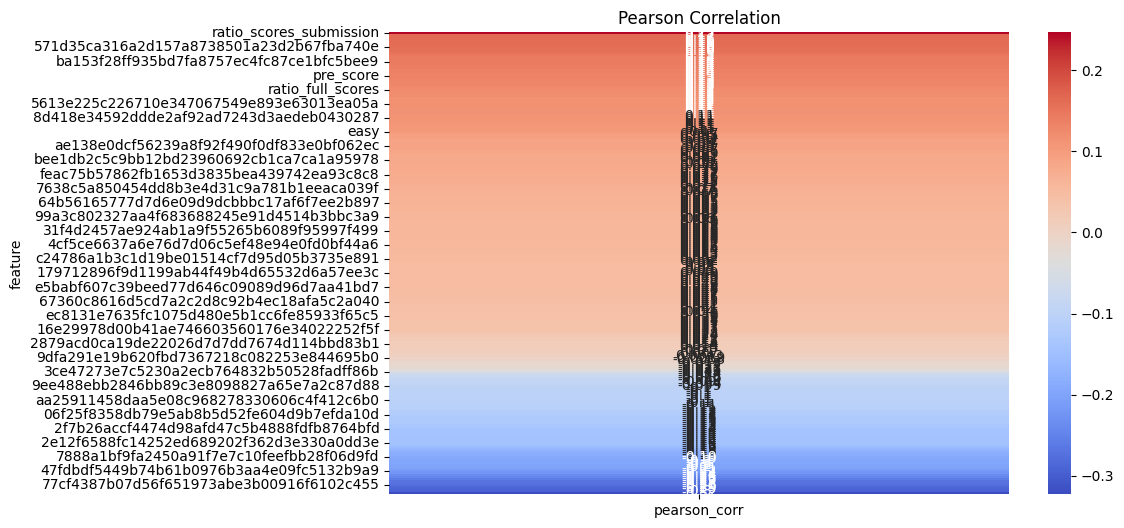

Text(0.5, 1.0, 'Spearman Correlation')

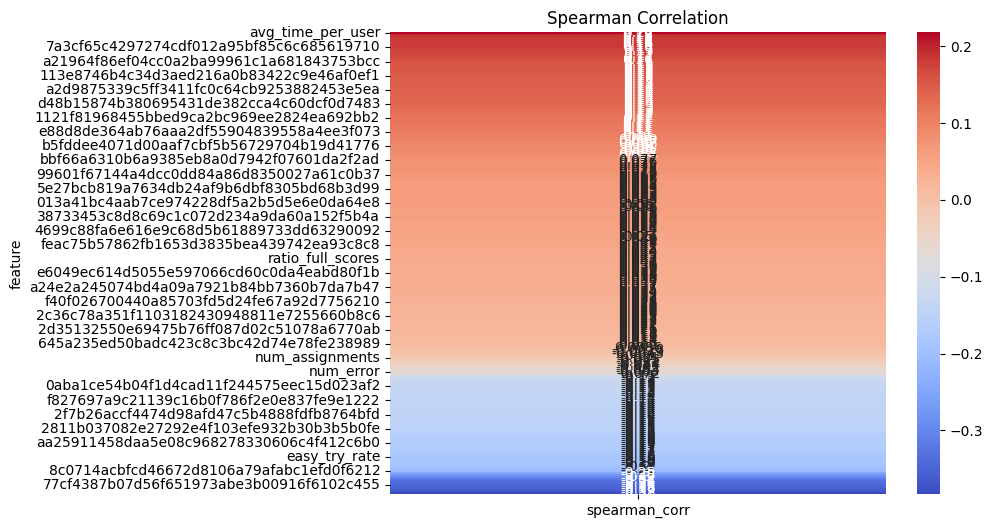

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(pearson_corr.to_frame(), annot=True, cmap='coolwarm')
plt.title('Pearson Correlation')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(spearman_corr.to_frame(), annot=True, cmap='coolwarm')
plt.title('Spearman Correlation')

In [33]:
chosen_features = pearson_corr.index.to_list()
chosen_features

['ratio_scores_submission',
 '49d4fef791afcea4da96d1316ca12eb1336dc4a7',
 '532bead181d6de0e33b6dd0b432d74455c32f902',
 '113e8746b4c34d3aed216a0b83422c9e46af0ef1',
 'f89d30fccecbe52278b59e9294d868e3c51fbff4',
 '0ced89de3d75ce8ddfe6b72e6b9cc93ce375dfe1',
 '613aea04c978f5e72fffc8bcff1f7b695a63f7b1',
 '571d35ca316a2d157a8738501a23d2b67fba740e',
 'bbd98d5c6b654897954d057af9ef7ff371e0b8e3',
 'd48b15874b380695431de382cca4c60dcf0d7483',
 'c618f3ac561dc6be61b1a179901d41e4371c0cf1',
 'e78a8215337b6bd71d1d768a1ab49122f32d1bde',
 '9418248b5e1773f0830d883b5a805d28de93ce9b',
 '03c6ca1a06d190e840f2a268206547e3b811ee53',
 'ba153f28ff935bd7fa8757ec4fc87ce1bfc5bee9',
 '7a3cf65c4297274cdf012a95bf85c6c685619710',
 '80a49018a0d5a814270c8012d7becdc053c87880',
 '4e006d0e16449cee52a2f5e04597b766488d8502',
 'c2ff95693b6747a542144976bf24801b01d78714',
 '781676f2e317b719c2b45aa07fb907149a8cb347',
 'a1f0b2fd3f5c26646266038250ec464dedbea71a',
 'pre_score',
 'e575df7d08a0629b70ca925cc05be3929d41f417',
 'hard',
 '02

# **Modeling**

## Chuẩn bị dữ liệu train, test

In [34]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np

data = summary_df.copy()
data = data.merge(df, on='username', how='inner')
# data.dropna(subset=[target], inplace=True)

X = data[chosen_features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## CatBoost

In [35]:
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV

model = CatBoostRegressor(verbose=0, random_state=42)

param_grid = {
    'iterations': [50, 100, 300],
    'depth': [4, 6, 8],
    'learning_rate': [0.001, 0.01, 0.05],
    'l2_leaf_reg': [1, 3, 5, 7]
}



# param_grid = {
#     'iterations': [50],
#     'depth': [4],
#     'learning_rate': [0.01],
#     'l2_leaf_reg': [3]
# }

grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           scoring='r2', cv=5, n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best R² score (validation):", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Test R² score:", r2_score(y_test, y_pred))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'depth': 4, 'iterations': 300, 'l2_leaf_reg': 1, 'learning_rate': 0.05}
Best R² score (validation): 0.3571961019921444
Test RMSE: 1.3401928466803765
Test R² score: 0.4293699789134172


In [36]:
summary_df['predicted'] = best_model.predict(summary_df[chosen_features])

summary_df['predicted'] = summary_df['predicted'].round(2)
print(summary_df[['username', 'predicted']].head())

                                   username  predicted
0  9f605b4802c811805adc38ae19035ded09a5e4b5       8.90
1  2cd5132c3c49bd9d4d5081e386a4d69a593f850a       6.28
2  58f61331a385caeed17baaf54abea308426d50fe       9.12
3  1abf62f1e76bc5ac164061cff2a8171d6b6de657       7.57
4  33b16210a7736a6f75ef1b1f3cb7070a4d29395e       9.12


In [37]:
summary_df[['username', 'predicted']].to_csv(
    'catb.txt', index=False, header=False
)

## XGBoost

In [38]:
summary_df = summary_df.drop('predicted', axis=1)

In [39]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

model = XGBRegressor(random_state=42, verbosity=0)

param_grid = {
    'n_estimators': [20, 50, 100, 200],
    'max_depth': [1, 3, 5, 7],
    'learning_rate': [0.001, 0.01, 0.05, 0.1],
    'subsample': [0.4, 0.6, 0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}


# param_grid = {
#     'n_estimators': [20],
#     'max_depth': [1],
#     'learning_rate': [0.01],
#     'subsample': [0.4],
#     'colsample_bytree': [0.8]
# }


grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           scoring='r2',
                           cv=5,
                           n_jobs=-1,
                           verbose=1)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation R²:", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"Test RMSE: {rmse}")
print(f"Test R² score: {r2}")


Fitting 5 folds for each of 512 candidates, totalling 2560 fits
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.6}
Best cross-validation R²: 0.3579789643453518
Test RMSE: 1.3554048319634329
Test R² score: 0.416342481502575


In [40]:
summary_df['predicted'] = best_model.predict(summary_df[chosen_features])

summary_df['predicted'] = summary_df['predicted'].round(2)
print(summary_df[['username', 'predicted']].head())

                                   username  predicted
0  9f605b4802c811805adc38ae19035ded09a5e4b5       8.92
1  2cd5132c3c49bd9d4d5081e386a4d69a593f850a       6.15
2  58f61331a385caeed17baaf54abea308426d50fe       9.26
3  1abf62f1e76bc5ac164061cff2a8171d6b6de657       7.92
4  33b16210a7736a6f75ef1b1f3cb7070a4d29395e       9.03


In [41]:
summary_df[['username', 'predicted']].to_csv(
    'xgb.txt', index=False, header=False
)